In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

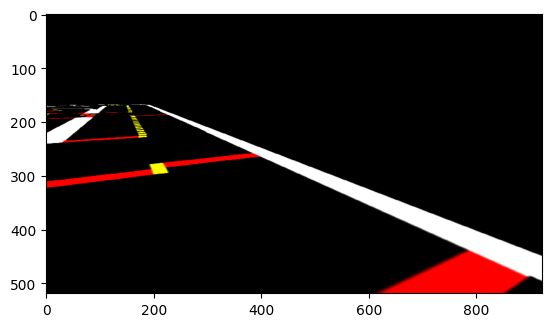

In [61]:
img = cv.imread('./sim_testing_images/at_stop.png')
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(rgb_img)


In [65]:
def get_yellow_blob_centers(bgr_img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Get grayscale image with only centerline (yellow colors)
    lower_yellow = np.array([240,240,0])
    upper_yellow = np.array([255,255,0])
    centerline_gray_img = cv.inRange(rgb_img, lower_yellow, upper_yellow) # get only yellow colors in image
    
    # Get Contours for center line blobs
    contours, hierarchy = cv.findContours(centerline_gray_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    centers = []
    for i in contours:
        M = cv.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if cy > rgb_img.shape[0]//2:
                cv.drawContours(rgb_img, [i], -1, (0,255,0), 2)
                cv.circle(rgb_img, (cx, cy), 7, (0, 0, 255), -1)
                centers.append((cx, cy))
                # print(f"x: {cx}, y: {cy}")

    return centers

def get_red_blob_centers(bgr_img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Get grayscale image with only centerline (yellow colors)
    lower_red = np.array([240,0,0])
    upper_red = np.array([255,0,0])
    stopline_gray_img = cv.inRange(rgb_img, lower_red, upper_red) # get only yellow colors in image
    
    # Get Contours for center line blobs
    contours, hierarchy = cv.findContours(stopline_gray_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    centers = []
    for i in contours:
        M = cv.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if cx > rgb_img.shape[1]/4 and cx < rgb_img.shape[1]*3/4 and cy > rgb_img.shape[0]/2:
                cv.drawContours(rgb_img, [i], -1, (0,255,0), 2)
                cv.circle(rgb_img, (cx, cy), 7, (0, 0, 255), -1)
                centers.append((cx, cy))
                # print(f"x: {cx}, y: {cy}")

    return centers


In [39]:
centers = get__yellow_blob_centers(img)



[(491, 195), (404, 192), (403, 186)]


# PID Control 

In [5]:
from simple_pid import PID

pid = PID()
pid.Ki = -.01*0
pid.Kd = -.5*1
pid.Kp = -30/300 #degrees per pixel
pid.sample_time = 1/30.0
pid.output_limits = (-30,30)


#set point is the desired location of the blob we are trying to follow
#find blob closest to car (bottom of camera aview)
centers.sort(key = lambda x: x[1])
blobToFollowCoords = centers[-1]

#get image coords
desXCoord = rgb_img.shape[1]//2
print(f"setpoint: {desXCoord}")
pid.setpoint = desXCoord

steeringAngle = pid(blobToFollowCoords[0])
print(f"input: {blobToFollowCoords[0]}")
print(steeringAngle)


setpoint: 461
input: 368
-9.3
PID(Kp=-0.1, Ki=-0.0, Kd=-0.0, setpoint=461, sample_time=0.03333333333333333, output_limits=(-30, 30), auto_mode=True, proportional_on_measurement=False, differetial_on_measurement=True, error_map=None)


In [66]:
# PID for speed
from simple_pid import PID

red_centers = get_red_blob_centers(img)
print(red_centers)
pid = PID()
pid.Ki = -.01*0
pid.Kd = -.5*0
pid.Kp = 2/400 # speed per pixel
pid.sample_time = 1/30.0
pid.output_limits = (0.0, 2.0)

#set point is the desired location of the blob we are trying to follow
#find blob closest to car (bottom of camera aview)
if len(red_centers) != 0:
    red_centers.sort(key = lambda x: x[0])
    stopLineCoords = red_centers[-1]

    #get image coords
    desDist = rgb_img.shape[1]-100
    print(f"setpoint: {desDist}")
    pid.setpoint = desDist

    speed = pid(blobToFollowCoords[1])

    print(f"input: {blobToFollowCoords[1]}")
    print(speed)


[(303, 271)]
setpoint: 823
input: 483
1.7


# Average Blobbing

In [ ]:
img = cv.imread('./sim_testing_images/straight_before_turn.png')
